In [2]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt

In [2]:
# load mask labelled points
labelled_points = np.load("mask.npz")["arm_keypoints"]

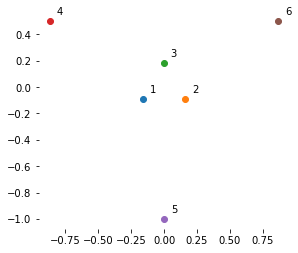

In [3]:
def euclidean_distance(point1, point2):
    """
    Calculate the euclidean distance between two points
    """
    return np.linalg.norm(point1 - point2)

arm_length = 1.0
arm_width = arm_length * np.mean([np.mean([
    euclidean_distance(labelled_points[i][0],labelled_points[i][1]),
    euclidean_distance(labelled_points[i][1],labelled_points[i][2]),
    euclidean_distance(labelled_points[i][2],labelled_points[i][0])
]) / np.mean([
    euclidean_distance(labelled_points[i][3],(labelled_points[i][0]+labelled_points[i][1]+labelled_points[i][2])/3),
    euclidean_distance(labelled_points[i][4],(labelled_points[i][0]+labelled_points[i][1]+labelled_points[i][2])/3),
    euclidean_distance(labelled_points[i][5],(labelled_points[i][0]+labelled_points[i][1]+labelled_points[i][2])/3)
]) for i in range(len(labelled_points))])

reward_distance = 0.8
origin = np.array([0.0, 0.0])

# get three corners of a triangle
k1 = origin + arm_width/np.sqrt(3) * np.array([np.cos(np.pi/2+2*np.pi/3), np.sin(np.pi/2+2*np.pi/3)])
k2 = origin + arm_width/np.sqrt(3) * np.array([np.cos(np.pi/2+4*np.pi/3), np.sin(np.pi/2+4*np.pi/3)])
k3 = origin + arm_width/np.sqrt(3) * np.array([np.cos(np.pi/2), np.sin(np.pi/2)])

# get the endpoints of the arm
k4 = origin + arm_length * np.array([np.cos(np.pi/6+2*np.pi/3), np.sin(np.pi/6+2*np.pi/3)])
k5 = origin + arm_length * np.array([np.cos(np.pi/6+4*np.pi/3), np.sin(np.pi/6+4*np.pi/3)])
k6 = origin + arm_length * np.array([np.cos(np.pi/6), np.sin(np.pi/6)])

# plot the triangles
for i,k in enumerate([k1, k2, k3, k4, k5, k6]):
    plt.plot(k[0], k[1], 'o')
    plt.text(k[0] + 0.05, k[1] + 0.05, str(i+1))

plt.gca().set_aspect('equal')
plt.box()
plt.show()

reference_points = np.array([k1, k2, k3, k4, k5, k6])

In [45]:
from skimage.transform import estimate_transform, AffineTransform

estimated_transforms = []
for i in range(len(labelled_points)):
    # get the points
    points = labelled_points[i]
    # get the affine transform
    transform = estimate_transform("affine", points, reference_points)
    # add to the list
    estimated_transforms.append(transform)

def realign_lr(start_arm,point,arena_index):
    clockwise_arenas = [0, 2, 4, 6, 8, 10, 12, 14]
    if start_arm==1.0:
        transform = AffineTransform(scale=(1.0, 1.0), rotation=0, translation=(0.0, 0.0))
    elif start_arm==2.0:
        transform = AffineTransform(scale=(1.0, 1.0), rotation=-2*np.pi/3, translation=(0.0, 0.0))
    elif start_arm==0.0:
        transform = AffineTransform(scale=(1.0, 1.0), rotation=2*np.pi/3, translation=(0.0, 0.0))
    else:
        raise ValueError("start_arm must be 0, 1 or 2")
    if arena_index in clockwise_arenas:
        return transform(point)*np.array([-1,1])
    else:
        return transform(point)

def realign_odor(odor_vector,point):
    if np.all(odor_vector==[1.0, 0.0, 2.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=0, translation=(0.0, 0.0))
        return transform(point)
    elif np.all(odor_vector==[2.0, 0.0, 1.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=0, translation=(0.0, 0.0))
        return transform(point)*np.array([-1.0, 1.0])
    elif np.all(odor_vector==[0.0, 1.0, 2.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=2*np.pi/3, translation=(0.0, 0.0))
        return transform(point)*np.array([-1.0, 1.0])
    elif np.all(odor_vector==[0.0, 2.0, 1.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=2*np.pi/3, translation=(0.0, 0.0))
        return transform(point)
    elif np.all(odor_vector==[1.0, 2.0, 0.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=-2*np.pi/3, translation=(0.0, 0.0))
        return transform(point)*np.array([-1.0, 1.0])
    elif np.all(odor_vector==[2.0, 1.0, 0.0]):
        transform = AffineTransform(scale=(1.0, 1.0), rotation=-2*np.pi/3, translation=(0.0, 0.0))
        return transform(point)
    elif np.isnan(odor_vector):
        return np.array([np.ones_like(point)*np.nan])
    else:
        raise ValueError("odor vector must be [1.0, 0.0, 2.0], [2.0, 0.0, 1.0], [0.0, 1.0, 2.0], [0.0, 2.0, 1.0], [1.0, 2.0, 0.0] or [2.0, 1.0, 0.0]")

def relative_to_absolute_arm( relative_position, start_arm, arena_index):
    if arena_index in [0, 2, 4, 6, 8, 10, 12, 14]:
        if relative_position == 0:
            return start_arm
        elif relative_position == 1:
            return (start_arm + 1) % 3
        elif relative_position == 2:
            return (start_arm - 1) % 3
    else:
        if relative_position == 0:
            return start_arm
        elif relative_position == 1:
            return (start_arm - 1) % 3
        elif relative_position == 2:
            return (start_arm + 1) % 3

C:\Users\labadmin\AppData\Local\Temp/ipykernel_45828/3558931729.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  current_odor_vectors = np.array(odor_vectors)[current_trials]


1.0 1.0


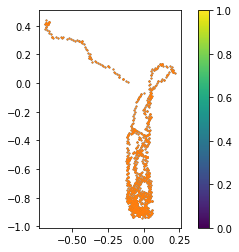

2.0 2.0


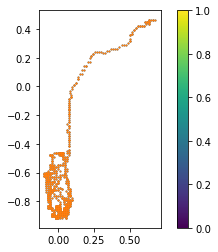

2.0 2.0


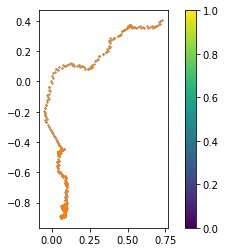

1.0 1.0


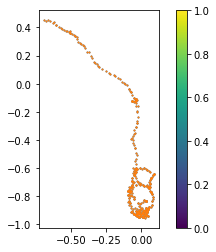

2.0 2.0


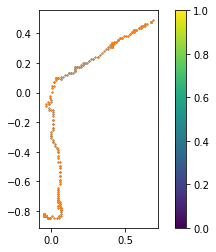

1.0 1.0


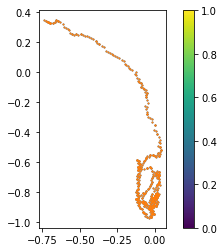

2.0 2.0


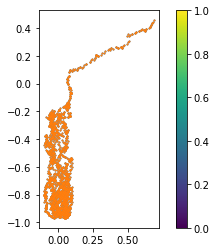

2.0 2.0


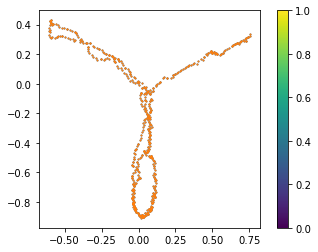

1.0 1.0


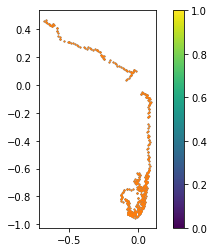

1.0 1.0


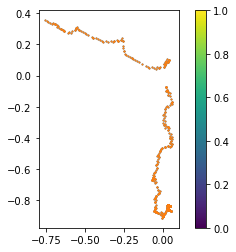

2.0 2.0


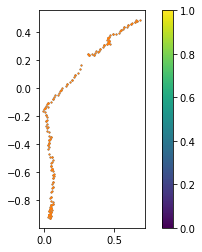

1.0 1.0


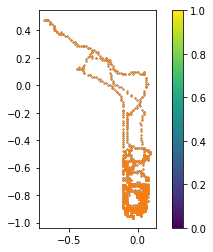

1.0 1.0


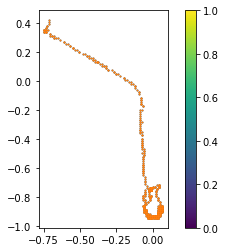

2.0 2.0


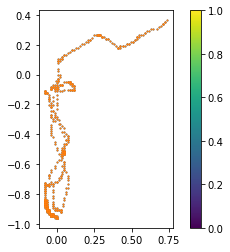

2.0 2.0


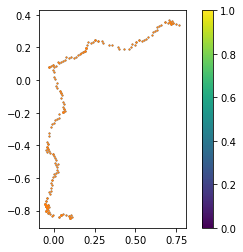

1.0 1.0


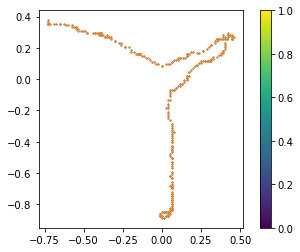

In [46]:
for i in os.listdir("data"):
    if i.endswith(".ydata"):
        with open("data/" + i, "r") as f:
            data = json.load(f)
            
        # get index of the arena
        index = int(i.split(".")[0].split("_")[-1])
        # get fly position
        fly_position = np.array(data['fly_positions'])
        # switch x and y
        fly_position = fly_position[:, [1, 0]]
        # get the estimated transform
        transform = estimated_transforms[index]
        # add the transformed fly position
        reference_fly_positions = transform(fly_position)
        # calculate instantaneous speed
        speed = np.linalg.norm(np.diff(reference_fly_positions, axis=0),axis=1)/np.diff(data['frame_times'], axis=0)
        # calculate instantaneous heading
        heading = np.arctan2(np.diff(reference_fly_positions[:, 1], axis=0), np.diff(reference_fly_positions[:, 0], axis=0))
        # calculate upwind speed
        radial_distance = np.linalg.norm(reference_fly_positions-origin, axis=1)
        upwind_speed = np.diff(radial_distance, axis=0)/np.diff(data['frame_times'], axis=0)
        # calculate upwind orientation
        upwind_orientation = np.arctan2(np.diff(reference_fly_positions[:, 1], axis=0), np.diff(reference_fly_positions[:, 0], axis=0)) - \
                            np.arctan2 (reference_fly_positions[:-1,1]-origin[1], reference_fly_positions[:-1,0]-origin[0])
        # calculate current trial
        start_arms = data['start_arms']
        odor_vectors = data['odor_vectors']
        start_arms.append(relative_to_absolute_arm(data['chosen_arms'][-1], start_arms[-1], index))
        odor_vectors.append(np.nan)
        current_trials = np.int32(np.array(data['current_trial']))
        current_start_arms = np.array(start_arms)[current_trials]
        current_odor_vectors = np.array(odor_vectors)[current_trials]
        # calculate trial oriented position
        trial_oriented_position = np.array([realign_lr(current_start_arms[i], reference_fly_positions[i], index) for i in range(len(data['frame_times']))]).squeeze()
        # calculate odor oriented position
        odor_oriented_position = np.array([realign_odor(current_odor_vectors[i], reference_fly_positions[i]) for i in range(len(data['frame_times']))]).squeeze()
        # calculate rewarded framews
        trial_changed = np.diff(data['current_trial']+[data['current_trial'][-1]+1], axis=0)
        rewarded_frames = np.array(data['reward_delivered']+[0])[np.int32(data['current_trial'])]*trial_changed
        
        
        
        
        
        
        # # plot the transformed fly position
        plt.scatter(trial_oriented_position[current_trials==5, 0], trial_oriented_position[current_trials==5, 1],s=1)
        plt.scatter(odor_oriented_position[current_trials==5, 0], odor_oriented_position[current_trials==5, 1],s=1)
        print(data['chosen_arms'][5], data['chosen_odor'][5])
        plt.colorbar()
        plt.gca().set_aspect('equal')
        plt.show()

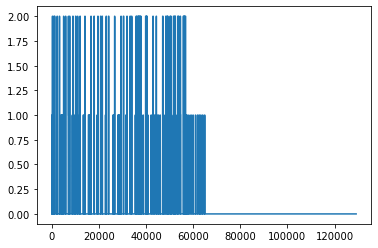

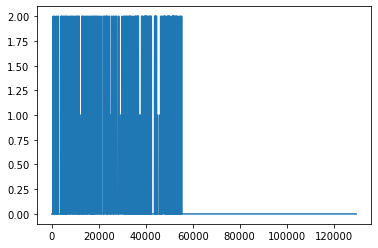

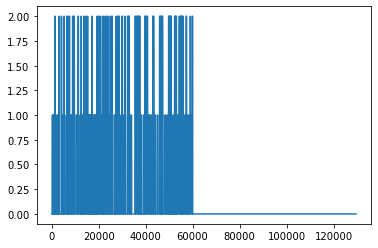

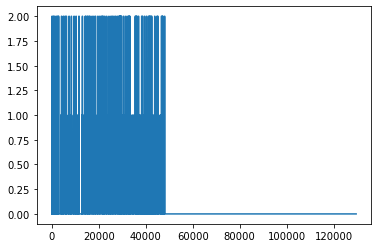

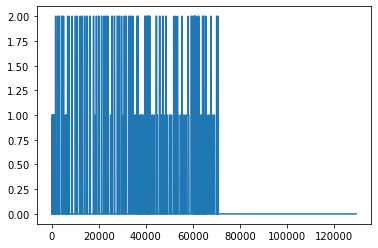

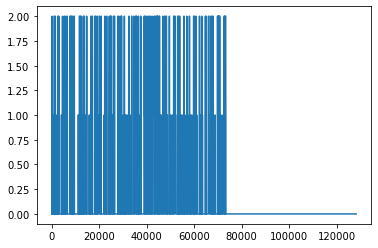

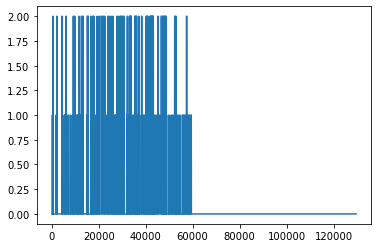

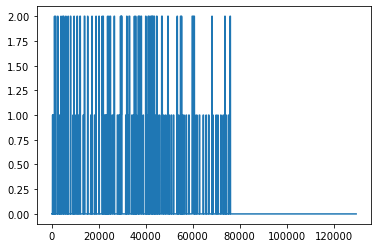

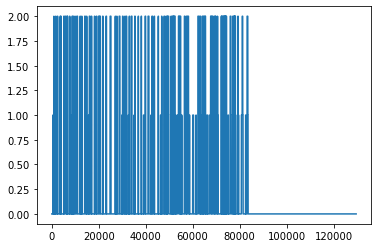

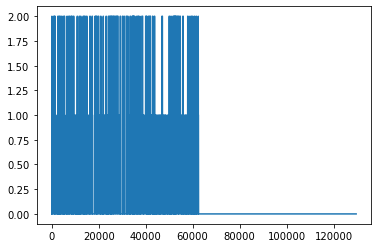

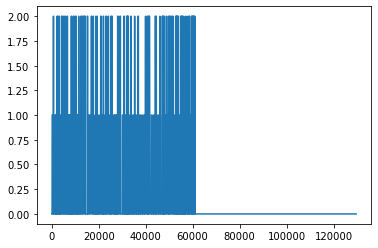

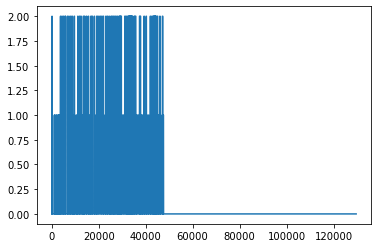

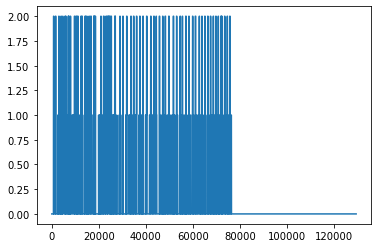

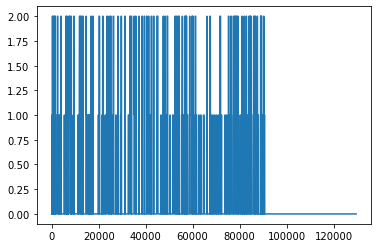

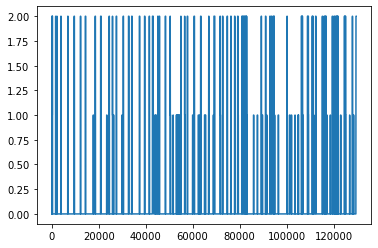

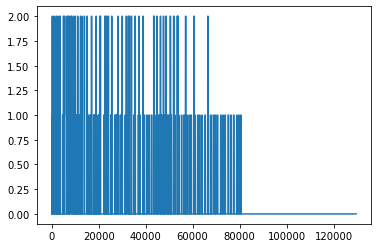

In [23]:
all_data = []
for i in range(16):
    with open(f"processed_data/fly_{i}.ydata", "r") as f:
        data = json.load(f)
        plt.plot(data['current_odor'])
        plt.show()
        all_data.append(data)


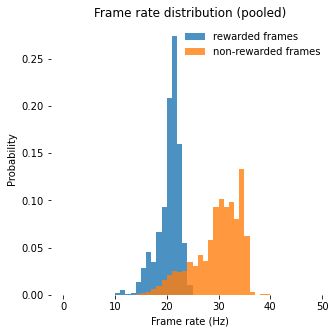

In [11]:
# plot the frame rate distribution
fig, ax = plt.subplots(figsize=(5, 5))

pooled_rewarded_frames = np.concatenate([data['rewarded_frames'][:-1] for data in all_data])
pooled_frame_rates = np.concatenate([1/np.diff(data['frame_times']) for data in all_data])

plt.hist(pooled_frame_rates[pooled_rewarded_frames==1], bins=np.arange(0,50,1), density=True, alpha=0.8, label="rewarded frames")
plt.hist(pooled_frame_rates[pooled_rewarded_frames==0], bins=np.arange(0,50,1), density=True, alpha=0.8, label="non-rewarded frames")
plt.box(False)
plt.xlabel("Frame rate (Hz)")
plt.ylabel("Probability")
plt.title("Frame rate distribution (pooled)")
plt.legend(frameon=False)
plt.show()

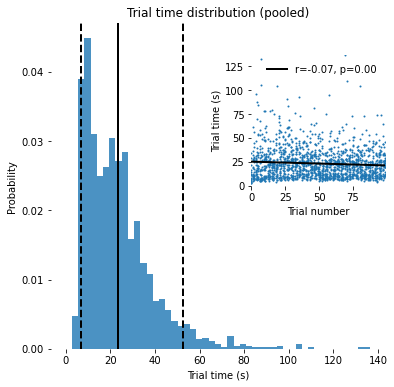

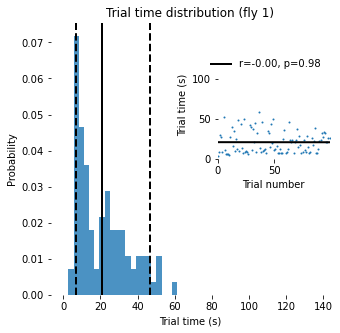

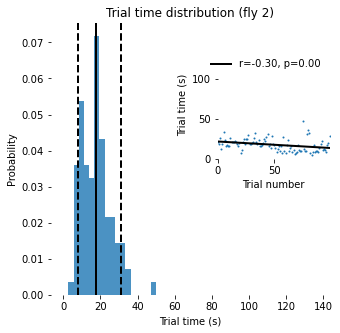

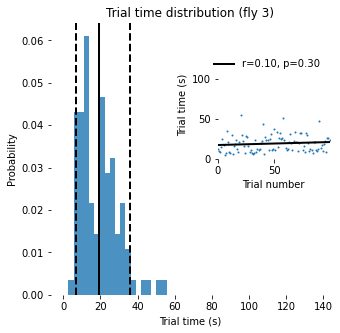

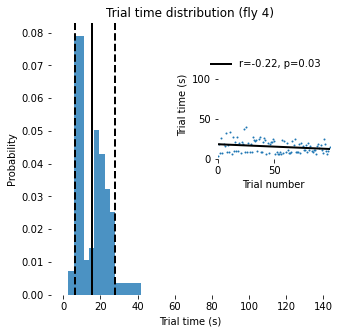

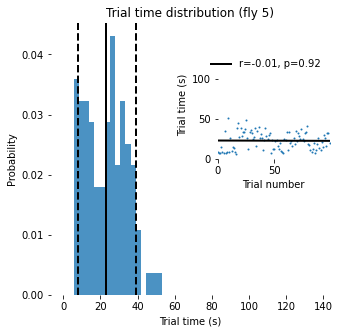

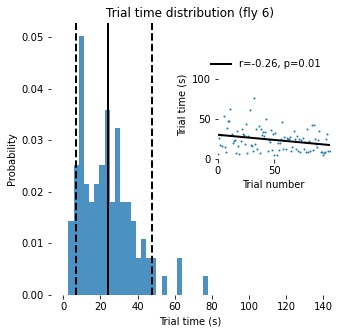

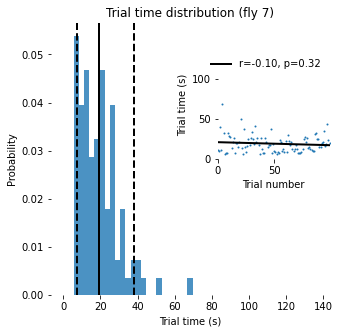

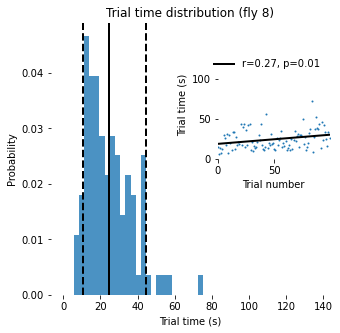

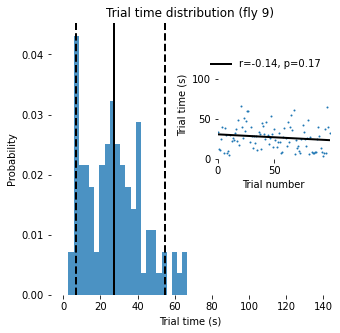

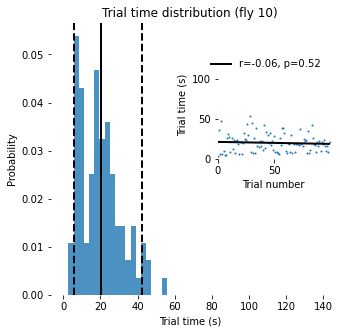

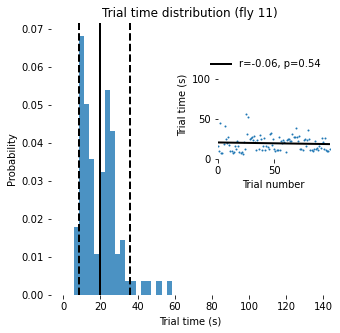

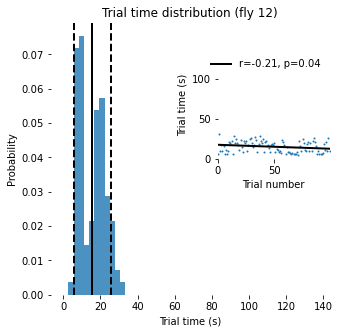

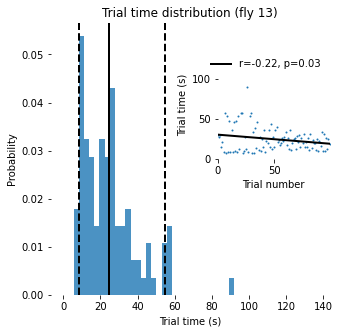

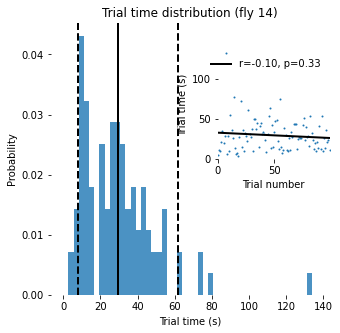

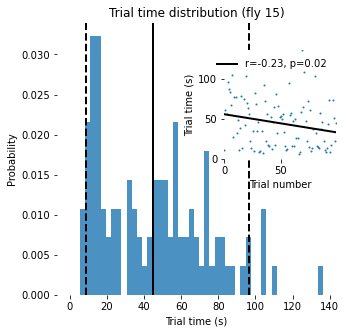

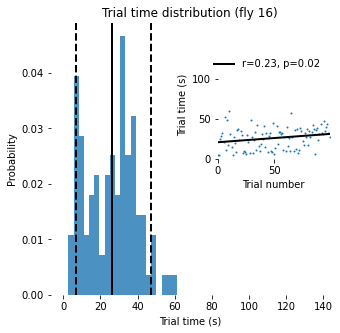

In [12]:
from scipy import stats

# plot the trial time distribution (pooled and individual)
pooled_trial_times = np.array([data['lengths_of_trials'] for data in all_data])
pooled_trial_numbers = np.array([np.arange(len(data['lengths_of_trials'])) for data in all_data])

bins = np.linspace(0, np.max(pooled_trial_times), 50)

fig, ax = plt.subplots(figsize=(6, 6))
plt.hist(np.concatenate(pooled_trial_times), bins=bins, density=True, alpha=0.8)
plt.axvline(pooled_trial_times.mean(), color='k', linestyle='solid', linewidth=2)
plt.axvline(np.percentile(pooled_trial_times, 5), color='k', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(pooled_trial_times, 95), color='k', linestyle='dashed', linewidth=2)
plt.box(False)
plt.xlabel("Trial time (s)")
plt.ylabel("Probability")
plt.title("Trial time distribution (pooled)")

axins = ax.inset_axes([0.6, 0.5, 0.4, 0.4])
axins.scatter(np.concatenate(pooled_trial_numbers), np.concatenate(pooled_trial_times), s=1)
# show linear regression along with p-value
slope, intercept, r_value, p_value, std_err = stats.linregress(np.concatenate(pooled_trial_numbers), np.concatenate(pooled_trial_times))
axins.plot(np.concatenate(pooled_trial_numbers), slope*np.concatenate(pooled_trial_numbers)+intercept, color='k', linestyle='solid', linewidth=2, label=f"r={r_value:.2f}, p={p_value:.2f}")
axins.set_xlim(0, np.max(pooled_trial_numbers))
axins.set_ylim(0, np.max(pooled_trial_times))
axins.set_xlabel("Trial number")
axins.set_ylabel("Trial time (s)")
for spine in axins.spines.values():
    spine.set_visible(False)
axins.legend(frameon=False)




plt.show()

for i in range(len(all_data)):
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.hist(pooled_trial_times[i], bins=bins, density=True, alpha=0.8)
    plt.axvline(pooled_trial_times[i].mean(), color='k', linestyle='solid', linewidth=2)
    plt.axvline(np.percentile(pooled_trial_times[i], 5), color='k', linestyle='dashed', linewidth=2)
    plt.axvline(np.percentile(pooled_trial_times[i], 95), color='k', linestyle='dashed', linewidth=2)
    plt.box(False)
    plt.xlabel("Trial time (s)")
    plt.ylabel("Probability")
    plt.title(f"Trial time distribution (fly {i+1})")

    axins = ax.inset_axes([0.6, 0.5, 0.4, 0.4])
    axins.scatter(np.arange(len(pooled_trial_times[i])), pooled_trial_times[i], s=1)
    # show linear regression along with p-value
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(pooled_trial_times[i])), pooled_trial_times[i])
    axins.plot(np.arange(len(pooled_trial_times[i])), slope*np.arange(len(pooled_trial_times[i]))+intercept, color='k', linestyle='solid', linewidth=2, label=f"r={r_value:.2f}, p={p_value:.2f}")
    axins.set_xlim(0, np.max(pooled_trial_numbers))
    axins.set_ylim(0, np.max(pooled_trial_times))
    axins.set_xlabel("Trial number")
    axins.set_ylabel("Trial time (s)")
    for spine in axins.spines.values():
        spine.set_visible(False)
    axins.legend(frameon=False)

    plt.show()


In [6]:
data.keys()

dict_keys(['fly_positions', 'frame_times', 'current_arms', 'current_trial', 'chosen_arms', 'chosen_odor', 'reward_delivered', 'trial_start_times', 'trial_end_times', 'time_spent_in_reward_zone', 'lengths_of_trials', 'odor_vectors', 'trial_baited', 'reward_states', 'start_arms', 'n_trials', 'max_frame_count', 'trial_count', 'experiment_states', 'reference_fly_positions', 'instantaneous_speed', 'instantaneous_heading', 'instantaneous_upwind_speed', 'instantaneous_upwind_heading', 'rewarded_frames', 'trial_oriented_position', 'odor_oriented_position'])

In [68]:
# calculate arm-wise residence time per trial

current_odor = np.array(data['current_odor']) 
trials = np.int32(np.sort(np.unique(data['current_trial'])))
trials = trials[trials>-1]
odors = np.int32(np.sort(np.unique(current_odor)))

odor_residence_times = np.zeros((len(trials), len(odors)))

for trial_number in trials:
    trial_current_odor = current_odor[np.array(data['current_trial'])==trial_number]
    trial_frame_times = np.array(data['frame_times'])[np.array(data['current_trial'])==trial_number]
    # append a new arm to the start and end of the trial
    trial_odor_encounter = trial_current_odor.copy()
    trial_odor_encounter=np.append(trial_odor_encounter, trial_odor_encounter[-1]+1)
    # calculate every change in arm
    trial_odor_encounter=np.diff(trial_odor_encounter)!=0
    trial_odor_encounter_ = trial_odor_encounter.copy()
    trial_odor_encounter_[0] = True
    time_of_odor_encounter=trial_frame_times[trial_odor_encounter_]
    odor_at_encounter=trial_current_odor[trial_odor_encounter]
    # calculate duration of each arm
    odor_durations=np.diff(time_of_odor_encounter)
    # calculate residence time of each odor
    for odor in odors:
        odor_residence_times[trial_number,odor]=np.sum(odor_durations[odor_at_encounter==odor])

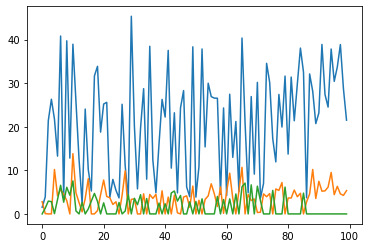

In [69]:
plt.plot(odor_residence_times[:-1,:])

In [181]:
for data in all_data:
    
    current_odor_ = np.insert(np.array(data['current_odor']), 0, 0)
    frame_times_ = np.insert(np.array(data['frame_times']), 0, data['frame_times'][0])
    current_trial_ = np.int32(np.insert(np.array(data['current_trial']), 0, data['current_trial'][0]))

    # calculate frames of odor encounter
    odor_encounter = current_odor_.copy()
    odor_encounter = np.append(odor_encounter, odor_encounter[-1]+1)
    odor_encounter = np.diff(odor_encounter)!=0
    odor_encounter_ = odor_encounter.copy()
    odor_encounter_[0] = True

    # calculate time of odor encounter
    time_of_odor_encounter=frame_times_[odor_encounter_]

    # calculate trial number of each encounter
    encounter_trial_number=current_trial_[odor_encounter]
    mask = encounter_trial_number < data['n_trials']
    encounter_trial_number = encounter_trial_number[mask]
    
    # calculate odor at each encounter
    encounter_odor = current_odor_[odor_encounter]
    encounter_odor = encounter_odor[mask]

    # calculate duration of each encounter
    encounter_durations=np.diff(time_of_odor_encounter)
    encounter_durations = encounter_durations[mask]

    # calculate encounter decision
    encounter_decisions=np.int32(np.diff(np.append(encounter_trial_number, encounter_trial_number[-1]+1))!=0)

    # calculate encounter reward
    encounter_rewards=np.int32(np.logical_and(np.array(data['reward_delivered'])[encounter_trial_number],encounter_decisions))
    
    # calculate encounter start time
    encounter_start_time=time_of_odor_encounter[:-1][mask]


    

129643 129139 216 217 False True
129643 129592 351 352 False True
129643 129625 249 250 False True
129643 129602 245 246 False True
129643 129271 241 242 False True
129643 128272 319 320 False True
129643 129644 218 219 False True
129643 129644 249 250 False True
129643 129626 262 263 False True
129643 129644 296 297 False True
129643 129644 266 267 False True
129643 129644 212 213 False True
129643 129432 360 361 False True
129643 129644 325 326 False True
129643 129644 271 272 False True
129643 129644 270 271 False True
269 269


In [187]:
encounter_decisions[encounter_odor==2]

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [104]:
data['reference_fly_positions']

[[0.6541611357588488, 0.25943227797337354],
 [0.5877149818285838, 0.22250122833010177],
 [0.5875761292510395, 0.20993712819523225],
 [0.5877149818285838, 0.22250122833010177],
 [0.5875761292510395, 0.20993712819523225],
 [0.5875761292510395, 0.20993712819523225],
 [0.5610254381944415, 0.19767752836489816],
 [0.5212688278983189, 0.1855701786868309],
 [0.4947181368417217, 0.17331057885649592],
 [0.481373365024651, 0.16089872887389323],
 [0.44161675472852746, 0.14879137919582597],
 [0.44147790215098315, 0.13622727906095644],
 [0.41492721109438513, 0.12396767923062146],
 [0.4015824392773153, 0.11155582924801966],
 [0.3882376674602437, 0.09914397926541785],
 [0.36168697640364744, 0.08688437943508287],
 [0.34834220458657583, 0.07447252945248106],
 [0.3217915135299796, 0.062212929622146085],
 [0.3085855942904532, 0.062365179774412915],
 [0.2686901314167853, 0.03769372996147613],
 [0.2553453595997137, 0.025281879978874322],
 [0.22879466854311747, 0.013022280148539345],
 [0.20224397748651946, 0